In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
DATA_DIR = "data/train"
DOMAIN_A_DIR = "data/train/A"
DOMAIN_B_DIR = "data/train/B"

In [4]:
PROCESS_DATA = 1
TRAIN_DATA = 1
IMG_SIZE = 200
BATCH_SIZE = 1

In [5]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
if PROCESS_DATA:
    dataset_A = datasets.ImageFolder(DOMAIN_A_DIR, transform=data_transform)
    dataloader_A = data.DataLoader(dataset_A, batch_size=BATCH_SIZE, num_workers= 2, shuffle= True)
    dataset_B = datasets.ImageFolder(DOMAIN_B_DIR, transform=data_transform)
    dataloader_B = data.DataLoader(dataset_B, batch_size=BATCH_SIZE, num_workers= 2, shuffle= True)

In [7]:
print("Domain A size: {}".format(len(dataset_A)))
print("Domain B size: {}".format(len(dataset_B)))

Domain A size: 1067
Domain B size: 1334


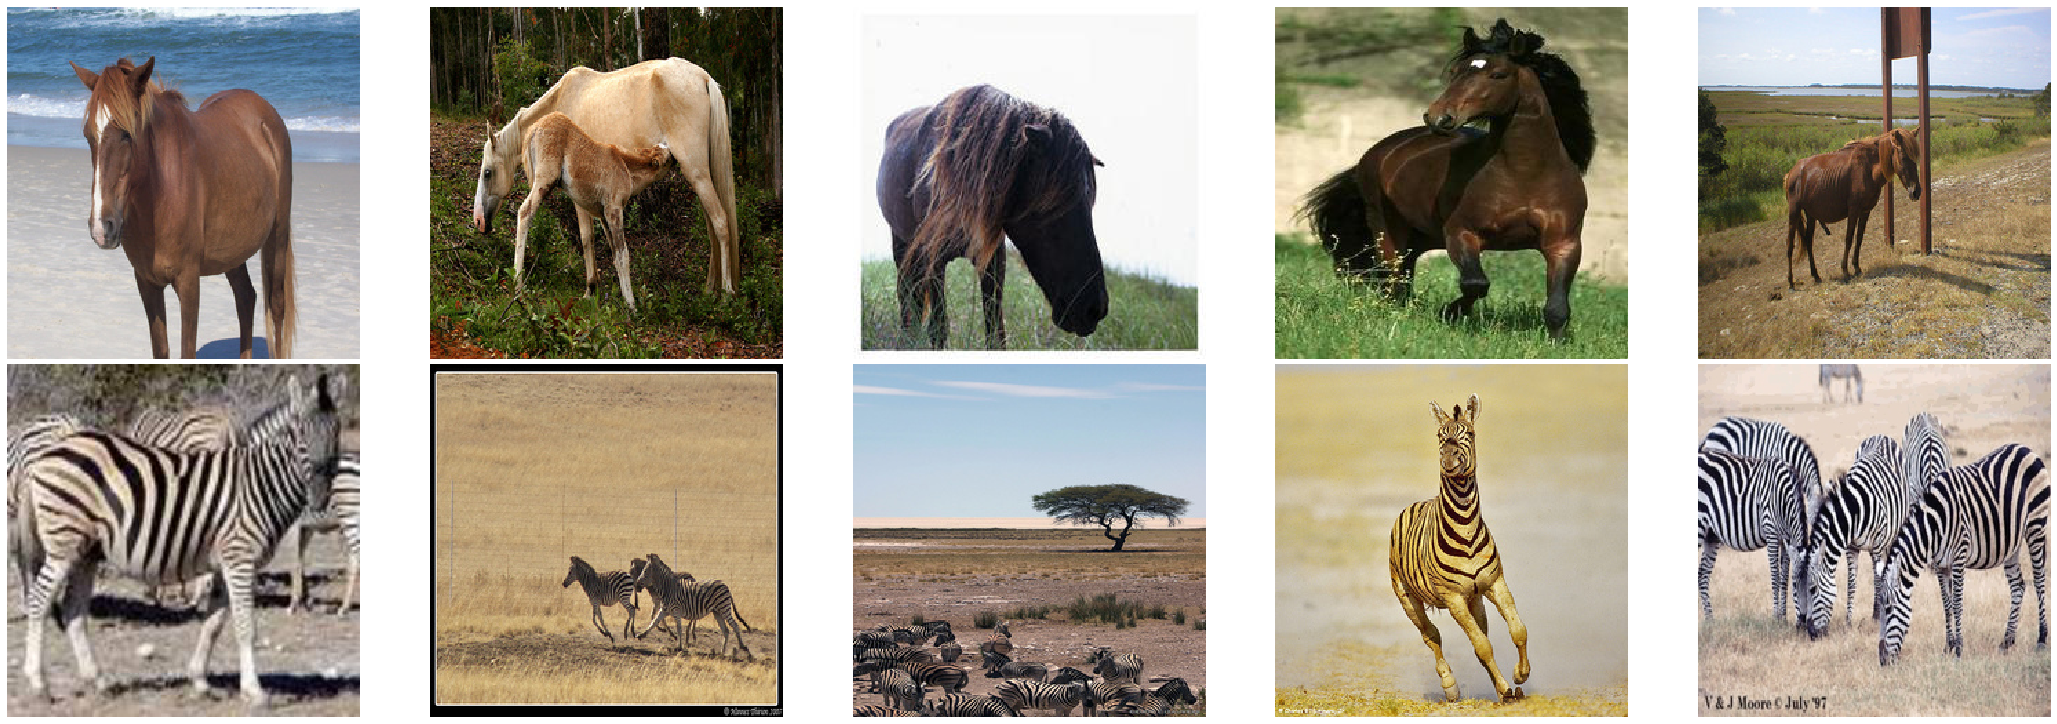

In [8]:
a = np.random.randint(1000)
fig = plt.figure(figsize=(30,10))
count = 1
for i in ["A/horse", "B/zebra"]:
    path = os.listdir(os.path.join(DATA_DIR, i))
    for f in path[a:a+5]:
        path1 = os.path.join(DATA_DIR, i,f)
        img = Image.open(path1)
        fig.add_subplot(2,5,count)
        plt.imshow(img)
        plt.axis("off")
        count+=1
fig.tight_layout(pad=0.5)   
plt.show()
        

In [9]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = np.random.uniform(0, 1)
                if p > 0.5:
                    random_id = np.random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [10]:
class ConvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,activation='relu',batch_norm=True):
        super(ConvBlock,self).__init__()
        self.conv = torch.nn.Conv2d(input_size,output_size,kernel_size,stride,padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.lrelu = torch.nn.LeakyReLU(0.2,True)
        self.tanh = torch.nn.Tanh()
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)
        
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [11]:
class DeconvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,output_padding=1,activation='relu',batch_norm=True):
        super(DeconvBlock,self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size,output_size,kernel_size,stride,padding,output_padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [12]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.resblock = nn.Sequential(
            nn.Conv2d(n_features,n_features, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(n_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_features,n_features, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(n_features)
        )
    
    def forward(self, x):
        x = self.resblock(x) + x
        return x

In [13]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # encoder
        self.hidden0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.hidden1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.hidden2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # transformer
        num_res_blocks = 9
        conv_layers = [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(256))
        self.res_blocks = nn.Sequential(*conv_layers)
        
        # decoder
        self.hidden3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.hidden4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.hidden5 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=7, stride=1, padding=3), #padding=1?
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.res_blocks(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        return x


In [14]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(.2, inplace=True)
        )
        self.hidden1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(.2, inplace=True),
        )
        self.hidden2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(.2, inplace=True)
        )
        self.hidden3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(.2, inplace=True),
        )
        self.out = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x
        

In [15]:
def generate_labels(size, label):
    if label == 1:
        data = torch.ones(size) - 0.1
    elif label == 0:
        data = torch.zeros(size)
    data = Variable(data).to(device)
    return data

In [16]:
def train_generator(D_A,D_B,G_A2B,G_B2A,optimizer_A,optimizer_B,error,cyclic_error,real_A, fake_A, real_B, fake_B):
    batch_size = real_A.size(0)
    G_A2B.zero_grad()
    G_B2A.zero_grad()
    
    """ # Identity losses #
    replicate_B       = G_A2B(real_B)
    loss_identity_B   = cyclic_error(replicate_B, real_B) * 5
        
    replicate_A       = G_B2A(real_A)
    loss_identity_A   = cyclic_error(replicate_A, real_A) * 5"""
    
    # Transform losses #
    predict_fake_B = D_B(fake_B)
    loss_G_A = error(predict_fake_B,generate_labels(predict_fake_B.size(),1))
    
    predict_fake_A = D_A(fake_A)
    loss_G_B = error(predict_fake_A,generate_labels(predict_fake_A.size(),1))
    
    # Cycle losses #
    cyclic_A = G_B2A(fake_B)
    loss_cyclic_A = cyclic_error(real_A,cyclic_A) * 10
    
    cyclic_B = G_A2B(fake_A)
    loss_cyclic_B = cyclic_error(cyclic_B,real_B) *10
    
    # Total Losses #
    loss_G = loss_G_A + loss_G_B + loss_cyclic_A + loss_cyclic_B #+ loss_identity_A + loss_identity_B
    loss_G.backward()
    optimizer_A.step()
    optimizer_B.step()
    
    return loss_G_A.data, loss_G_B.data, loss_cyclic_A.data, loss_cyclic_B.data

In [17]:
fake_A_pool = ImagePool(50)
fake_B_pool = ImagePool(50)

In [18]:
def train_discriminator(D_A,D_B,G_A2B,G_B2A,optimizer_A,optimizer_B,error,cyclic_error,real_A, fake_A, real_B, fake_B):
    batch_size = real_A.size(0)
    D_A.zero_grad()
    D_B.zero_grad()
    
    #Train Discriminator A
    predict_real_A = D_A(real_A)
    loss_real_A = error(predict_real_A,generate_labels(predict_real_A.size(),1))
    
    fake_A = fake_A_pool.query(fake_A)
    
    predict_fake_A = D_A(fake_A)
    loss_fake_A = error(predict_fake_A,generate_labels(predict_fake_A.size(),0))
    
    loss_D_A = (loss_real_A +loss_fake_A)*5
    loss_D_A.backward()
    optimizer_A.step()
    
    #Train Discriminator B
    predict_real_B = D_B(real_B)
    loss_real_B = error(predict_real_B,generate_labels(predict_real_B.size(),1))
    
    fake_B = fake_B_pool.query(fake_B)
    
    predict_fake_B = D_B(fake_B)
    loss_fake_B = error(predict_fake_B,generate_labels(predict_fake_B.size(),0))
    
    loss_D_B = (loss_real_B +loss_fake_B)*5
    loss_D_B.backward()
    optimizer_B.step()
    
    return loss_D_A.data, loss_D_B.data
    
    

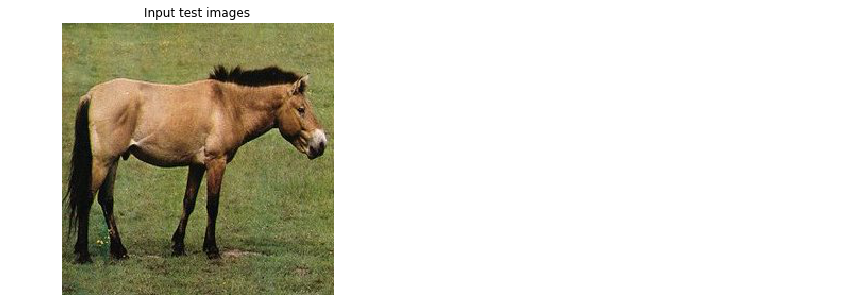

In [19]:
fixed_img_A = Image.open("data/test/testA/n02381460_3330.jpg")

fig = plt.figure(figsize=(15,5))
plt.axis("off")
fig.add_subplot(1,2,1)
plt.axis("off")
plt.title("Input test images")
plt.imshow(fixed_img_A)

plt.show()



In [20]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_show = img.cpu().numpy().squeeze().transpose((1,2,0))
    img_show = (img_show * std+mean)
    img_show = np.clip(img_show,0,1)
    return img_show

In [21]:
def generate_img(G_A2B, G_B2A, img, domain):
    G_A2B.eval()
    G_B2A.eval()
        
    img = Variable(data_transform(img)).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
    with torch.no_grad():
        img_show = imshow(img)
        if domain == "A":
            fake = G_A2B(img)
            fake_show = imshow(fake)
            reconstructed = G_B2A(fake)
            reconstructed_show = imshow(reconstructed)
        else:
            fake = G_B2A(img)
            fake_show = imshow(fake)
            reconstructed = G_A2B(fake)
            reconstructed_show = imshow(reconstructed)


    fig = plt.figure(figsize=(30,10))
    plt.title("Generator test")
    plt.axis("off")
    fig.add_subplot(1,3,1)
    plt.axis("off")
    plt.title("Real")
    plt.imshow(img_show)
    fig.add_subplot(1,3,2)
    plt.axis("off")
    plt.title("Generated")
    plt.imshow(fake_show)
    fig.add_subplot(1,3,3)
    plt.axis("off")
    plt.title("Reconstructed")
    plt.imshow(reconstructed_show)
    plt.show()
    
    plt.show()
    G_A2B.train()
    G_B2A.train()

In [22]:
nc = 3
ngf = 64
ndf = 64
num_resnet = 6

In [23]:
# input_dim, num_filter, output_dim, num_resnet
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
#generate_img(G_A2B,G_B2A,transform_A)
def train(dataloader_A, dataloader_B):
    
    # input_dim, num_filter, output_dim
    D_A = Discriminator().to(device)
    D_B = Discriminator().to(device)

    """G_A2B.normal_weight_init(mean=0.0, std=0.02)
    G_B2A.normal_weight_init(mean=0.0, std=0.02)
    D_A.normal_weight_init(mean=0.0, std=0.02)
    D_B.normal_weight_init(mean=0.0, std=0.02)"""

    G_A_optimizer = torch.optim.Adam(
        G_A2B.parameters(), lr=0.0002, betas=(0.5, 0.999))
    G_B_optimizer = torch.optim.Adam(
        G_B2A.parameters(), lr=0.0002, betas=(0.5, 0.999))
    D_A_optimizer = torch.optim.Adam(
        D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
    D_B_optimizer = torch.optim.Adam(
        D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

    MSE_error = nn.MSELoss()
    L1_error = nn.L1Loss()

    D_A_loss_list = []
    D_B_loss_list = []
    G_A_loss_list = []
    G_B_loss_list = []
    Cyclic_A_loss_list = []
    Cyclic_B_loss_list = []

    EPOCHS = 100

    print("Start training...")
    for epoch in range(EPOCHS):
        for i, (batch_A, batch_B) in enumerate(zip(dataloader_A, dataloader_B)):
            real_A = batch_A[0].to(device)
            real_B = batch_B[0].to(device)
            fake_A = G_B2A(real_A)
            fake_B = G_A2B(real_B)
            loss_G_A, loss_G_B, loss_cyclic_A, loss_cyclic_B = train_generator(D_A, D_B, G_A2B, G_B2A, G_A_optimizer, G_B_optimizer,
                                                                               MSE_error, L1_error, real_A, fake_A, real_B, fake_B)
            loss_D_A, loss_D_B = train_discriminator(D_A, D_B, G_A2B, G_B2A, D_A_optimizer, D_B_optimizer, MSE_error, L1_error, real_A,
                                                     fake_A, real_B, fake_B)

            D_A_loss_list.append(loss_D_A)
            D_B_loss_list.append(loss_D_B)
            G_A_loss_list.append(loss_G_A)
            G_B_loss_list.append(loss_G_B)
            Cyclic_A_loss_list.append(loss_cyclic_A)
            Cyclic_B_loss_list.append(loss_cyclic_B)

            if i % 360 == 0 or i == len(dataloader_A)-1:
                print("Epoch: ({}/{}) | Batch: ({}/{}) | D_A_Loss: {:.4f} D_B_Loss: {:.4f} | G_A_Loss: {:.4f} G_B_Loss: {:.4f} | C_A_Loss: {:.4f} C_B_Loss: {:.4f} |".format(
                    epoch+1, EPOCHS, i+1, len(dataloader_A), loss_D_A, loss_D_B, loss_G_A, loss_G_B, loss_cyclic_A, loss_cyclic_B))
        
        if epoch%3==0 or epoch == EPOCHS-1:
            ga_name = "model/generatorA-{}.pth".format(epoch)
            gb_name = "model/generatorB-{}.pth".format(epoch)
            torch.save(G_A2B.state_dict(), ga_name)
            torch.save(G_B2A.state_dict(), gb_name)
            generate_img(G_A2B, G_B2A, fixed_img_A, "A")
            
        if(epoch>50) :
            D_A_optimizer.param_groups[0]['lr'] -= (0.0002 / 50)
            D_B_optimizer.param_groups[0]['lr'] -= (0.0002 / 50)
            G_A_optimizer.param_groups[0]['lr'] -= (0.0002 / 50)  
            G_B_optimizer.param_groups[0]['lr'] -= (0.0002 / 50)
        
    print("Training Completed!")
    return G_A2B, G_B2A, D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list

Start training...
Epoch: (1/50) | Batch: (1/1067) | D_A_Loss: 9.7132 D_B_Loss: 7.6023 | G_A_Loss: 1.4143 G_B_Loss: 1.6333 | C_A_Loss: 13.0910 C_B_Loss: 11.0292 |
Epoch: (1/50) | Batch: (361/1067) | D_A_Loss: 3.7168 D_B_Loss: 0.7722 | G_A_Loss: 0.5243 G_B_Loss: 1.2826 | C_A_Loss: 5.6635 C_B_Loss: 13.1759 |
Epoch: (1/50) | Batch: (721/1067) | D_A_Loss: 1.1877 D_B_Loss: 0.2250 | G_A_Loss: 0.5791 G_B_Loss: 0.7344 | C_A_Loss: 5.6050 C_B_Loss: 9.2074 |
Epoch: (1/50) | Batch: (1067/1067) | D_A_Loss: 0.6542 D_B_Loss: 0.1896 | G_A_Loss: 0.9247 G_B_Loss: 0.4999 | C_A_Loss: 8.9902 C_B_Loss: 8.7286 |


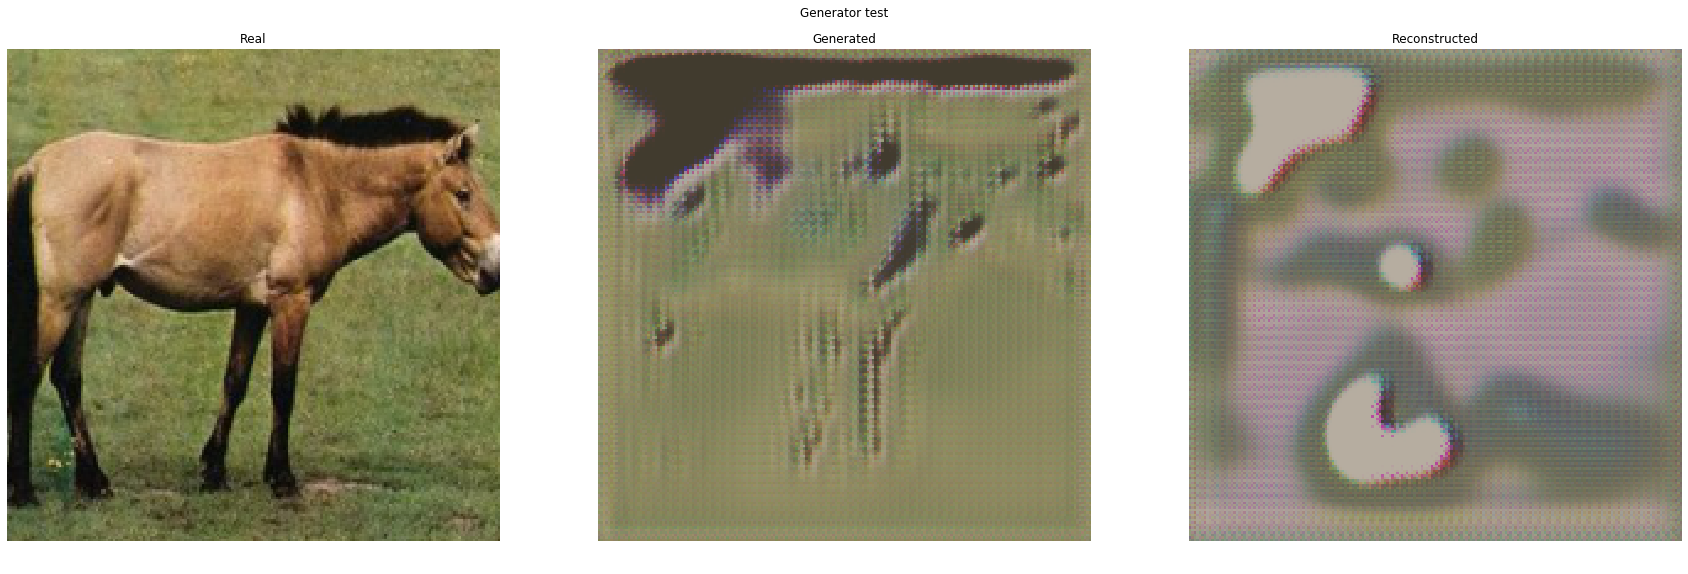

Epoch: (2/50) | Batch: (1/1067) | D_A_Loss: 0.8584 D_B_Loss: 0.6128 | G_A_Loss: 0.8010 G_B_Loss: 0.2857 | C_A_Loss: 10.8951 C_B_Loss: 6.9074 |
Epoch: (2/50) | Batch: (361/1067) | D_A_Loss: 0.2302 D_B_Loss: 0.8112 | G_A_Loss: 0.2038 G_B_Loss: 0.4518 | C_A_Loss: 11.1632 C_B_Loss: 12.2482 |
Epoch: (2/50) | Batch: (721/1067) | D_A_Loss: 0.6138 D_B_Loss: 0.1468 | G_A_Loss: 0.4038 G_B_Loss: 0.3850 | C_A_Loss: 8.2867 C_B_Loss: 9.2621 |
Epoch: (2/50) | Batch: (1067/1067) | D_A_Loss: 0.6103 D_B_Loss: 1.2924 | G_A_Loss: 0.2434 G_B_Loss: 0.9956 | C_A_Loss: 7.1794 C_B_Loss: 13.7097 |
Epoch: (3/50) | Batch: (1/1067) | D_A_Loss: 0.6376 D_B_Loss: 0.0604 | G_A_Loss: 0.5717 G_B_Loss: 0.7878 | C_A_Loss: 9.3806 C_B_Loss: 9.4970 |
Epoch: (3/50) | Batch: (361/1067) | D_A_Loss: 1.1973 D_B_Loss: 0.2958 | G_A_Loss: 0.5955 G_B_Loss: 0.3419 | C_A_Loss: 6.4787 C_B_Loss: 5.9860 |
Epoch: (3/50) | Batch: (721/1067) | D_A_Loss: 1.9482 D_B_Loss: 0.0946 | G_A_Loss: 0.7262 G_B_Loss: 0.1060 | C_A_Loss: 8.4464 C_B_Loss: 

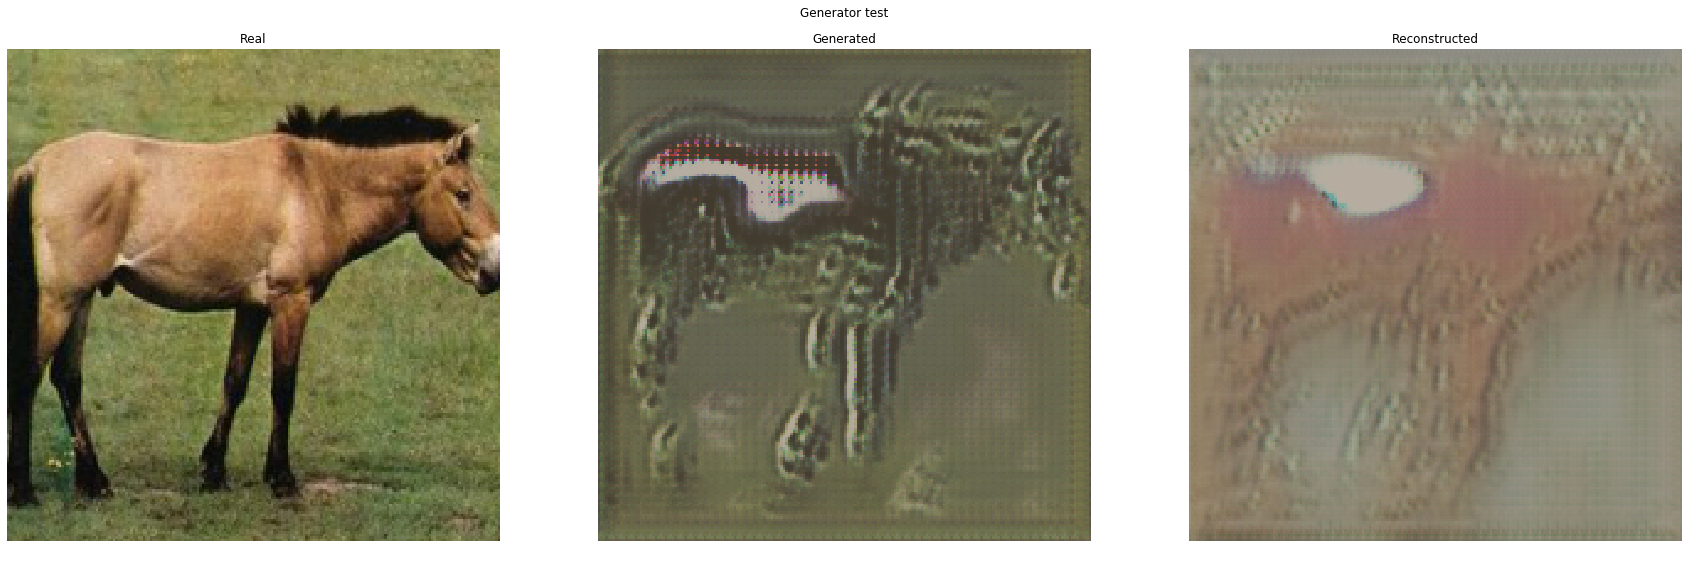

Epoch: (5/50) | Batch: (1/1067) | D_A_Loss: 0.4463 D_B_Loss: 0.7983 | G_A_Loss: 0.3508 G_B_Loss: 0.8187 | C_A_Loss: 8.3362 C_B_Loss: 7.8067 |
Epoch: (5/50) | Batch: (361/1067) | D_A_Loss: 0.1779 D_B_Loss: 0.3691 | G_A_Loss: 1.0576 G_B_Loss: 0.5607 | C_A_Loss: 9.2552 C_B_Loss: 7.7348 |
Epoch: (5/50) | Batch: (721/1067) | D_A_Loss: 0.1990 D_B_Loss: 0.5432 | G_A_Loss: 0.4082 G_B_Loss: 0.4556 | C_A_Loss: 8.3873 C_B_Loss: 8.7380 |
Epoch: (5/50) | Batch: (1067/1067) | D_A_Loss: 2.1366 D_B_Loss: 0.2529 | G_A_Loss: 0.4085 G_B_Loss: 0.1646 | C_A_Loss: 7.2416 C_B_Loss: 7.0200 |
Epoch: (6/50) | Batch: (1/1067) | D_A_Loss: 0.7083 D_B_Loss: 0.8151 | G_A_Loss: 0.3092 G_B_Loss: 0.9897 | C_A_Loss: 8.0492 C_B_Loss: 7.2973 |
Epoch: (6/50) | Batch: (361/1067) | D_A_Loss: 1.3133 D_B_Loss: 0.1994 | G_A_Loss: 0.5834 G_B_Loss: 0.2034 | C_A_Loss: 8.4298 C_B_Loss: 8.5876 |
Epoch: (6/50) | Batch: (721/1067) | D_A_Loss: 1.7043 D_B_Loss: 0.0895 | G_A_Loss: 0.6507 G_B_Loss: 0.3496 | C_A_Loss: 5.8961 C_B_Loss: 11.9

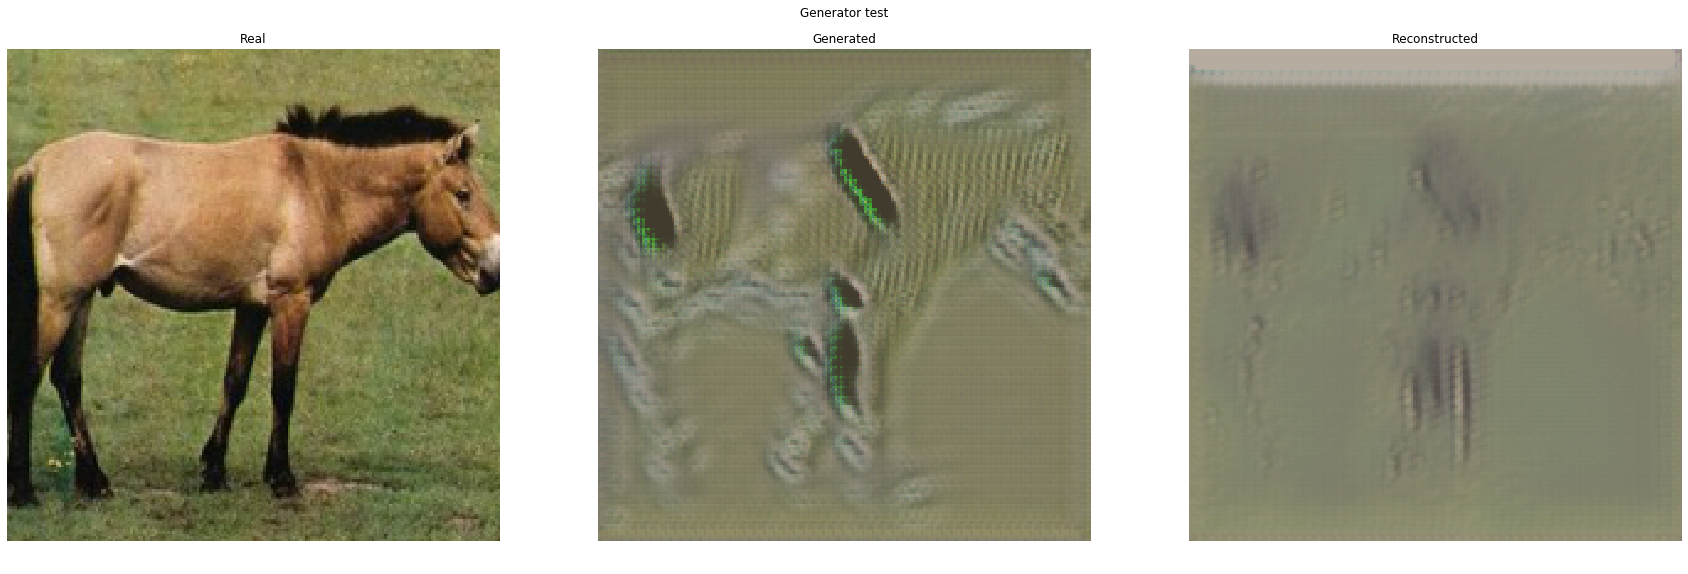

Epoch: (8/50) | Batch: (1/1067) | D_A_Loss: 1.6522 D_B_Loss: 0.4544 | G_A_Loss: 0.4136 G_B_Loss: 0.1480 | C_A_Loss: 6.3290 C_B_Loss: 10.2778 |
Epoch: (8/50) | Batch: (361/1067) | D_A_Loss: 0.2507 D_B_Loss: 0.1907 | G_A_Loss: 1.0010 G_B_Loss: 0.5738 | C_A_Loss: 6.5911 C_B_Loss: 13.5472 |
Epoch: (8/50) | Batch: (721/1067) | D_A_Loss: 1.9225 D_B_Loss: 1.1372 | G_A_Loss: 0.3742 G_B_Loss: 0.2254 | C_A_Loss: 8.5144 C_B_Loss: 8.8706 |


In [ ]:
if TRAIN_DATA:
    G_A2B, G_B2A, D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list = train(
        dataloader_A, dataloader_B)
    

In [ ]:
#Plot learning curves
def plot(D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list, EPOCHS=None):
    if EPOCHS is None:
        EPOCHS = len(D_A_loss_list)
    fig = plt.figure(figsize=(30,30))
    fig.add_subplot(2,1,1)
    plt.plot(range(EPOCHS), D_A_loss_list,label = "Discriminator A Loss")
    plt.plot(range(EPOCHS),D_B_loss_list, color ="orange",label = "Discriminator B Loss")
    plt.plot(range(EPOCHS),G_A_loss_list, color ="cyan",label = "Gennerator A Loss")
    plt.plot(range(EPOCHS),G_B_loss_list, color ="red",label = "Gennerator B Loss")
    plt.title("Learning Curve 1")
    plt.legend()
    
    fig.add_subplot(2,1,2)
    plt.plot(range(EPOCHS), Cyclic_A_loss_list,label = "Cycle A Loss")
    plt.plot(range(EPOCHS), Cyclic_B_loss_list, color ="orange",label = "Cycle B Loss")
    plt.title("Learning Curve 2")
    plt.legend()
    plt.show()
if TRAIN_DATA: 
    plot(D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list)

In [ ]:
test_A = Image.open("data/test/testA/n02381460_4660.jpg")
test_B = Image.open("data/test/testB/n02391049_4890.jpg")

generate_img(G_A2B,G_B2A,test_A,"A")
generate_img(G_A2B,G_B2A,test_B,"B")